In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
import xgboost as xgb
from scipy import stats

In [47]:
df =pd.read_csv('../../../data/preprocessed/feature_selection_by_dicision_tree_final_data_v3_30feature.csv')
X = df.drop(['price_per_m2'], axis=1)
y = df['price_per_m2']

In [48]:
y_log = np.log1p(y)


In [49]:
X_train, X_test, y_train_log, y_test_log = train_test_split(X, y_log, test_size=0.2, random_state=42)
y_train = np.expm1(y_train_log)
y_test = np.expm1(y_test_log)

In [50]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [51]:
param_grid = {
    'n_estimators': [300, 500, 700],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5, 6],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'gamma': [0, 0.1, 0.2],
    'reg_alpha': [0, 0.1, 0.5, 1],
    'reg_lambda': [0.5, 1, 1.5],
    'min_child_weight': [1, 3, 5]
}

In [52]:
xgb_model = XGBRegressor(
    objective='reg:absoluteerror', 
    tree_method='hist',
    random_state=42,
    n_jobs=-1
)

# Randomized search with MAE scoring
search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_grid,
    n_iter=50,
    scoring='neg_mean_absolute_error',
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

search.fit(X_train_scaled, y_train_log)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          feature_weights=None, gamma=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraint...
                                          num_parallel_tree=None, ...),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.7, 0.8, 0.9],
                                        'gamma': [0, 0.1, 0.2],
                                        'learning_rate': [0.01, 0.05, 0.1],
                                        'max_depth': [3, 4, 5, 6],
                                        'min_child_weight': [1, 3, 5],
                                        'n_estimators': [300, 500, 700],
                                        'reg_alpha': [0, 0.1, 0.5, 1],
                                        'reg_lambda': [0.5, 1, 1.5],
                                        'subsample': [0.7, 0.8, 0.9]},
                   random_state=42, scoring='neg_mean_absolute_error',
                   verbose=1)

In [53]:
best_xgb = search.best_estimator_
print(f"Best parameters: {search.best_params_}")
print(f"Best CV MAE: {-search.best_score_:.4f}")


Best parameters: {'subsample': 0.8, 'reg_lambda': 1.5, 'reg_alpha': 0.5, 'n_estimators': 700, 'min_child_weight': 5, 'max_depth': 6, 'learning_rate': 0.1, 'gamma': 0.2, 'colsample_bytree': 0.7}
Best CV MAE: 0.0775


In [54]:
best_xgb.fit(
    X_train_scaled, y_train_log,
    eval_set=[(X_test_scaled, y_test_log)],
    verbose=50
)

y_pred_train_log = best_xgb.predict(X_train_scaled)
y_pred_test_log = best_xgb.predict(X_test_scaled)

y_pred_train = np.expm1(y_pred_train_log)
y_pred_test = np.expm1(y_pred_test_log)

[0]	validation_0-mae:0.96693
[50]	validation_0-mae:0.14370
[100]	validation_0-mae:0.12088
[150]	validation_0-mae:0.10543
[200]	validation_0-mae:0.09645
[250]	validation_0-mae:0.09027
[300]	validation_0-mae:0.08624
[350]	validation_0-mae:0.08391
[400]	validation_0-mae:0.08149
[450]	validation_0-mae:0.07995
[500]	validation_0-mae:0.07887
[550]	validation_0-mae:0.07833
[600]	validation_0-mae:0.07723
[650]	validation_0-mae:0.07629
[699]	validation_0-mae:0.07555


In [55]:
def print_metrics(y_true, y_pred, set_name):
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / np.maximum(y_true, 1))) * 100
    
    print(f"\n{set_name} Metrics:")
    print(f"R²: {r2:.4f}")
    print(f"MAE: {mae:.2f}")
    print(f"MAPE: {mape:.2f}%")
    if set_name == "Test":
        print(f"Avg Price: {y_true.mean():.2f}")
    return mae

In [56]:
train_mae = print_metrics(y_train, y_pred_train, "Train")
test_mae = print_metrics(y_test, y_pred_test, "Test")


Train Metrics:
R²: 0.9961
MAE: 56.99
MAPE: 5.80%

Test Metrics:
R²: 0.9922
MAE: 102.86
MAPE: 7.97%
Avg Price: 2074.79


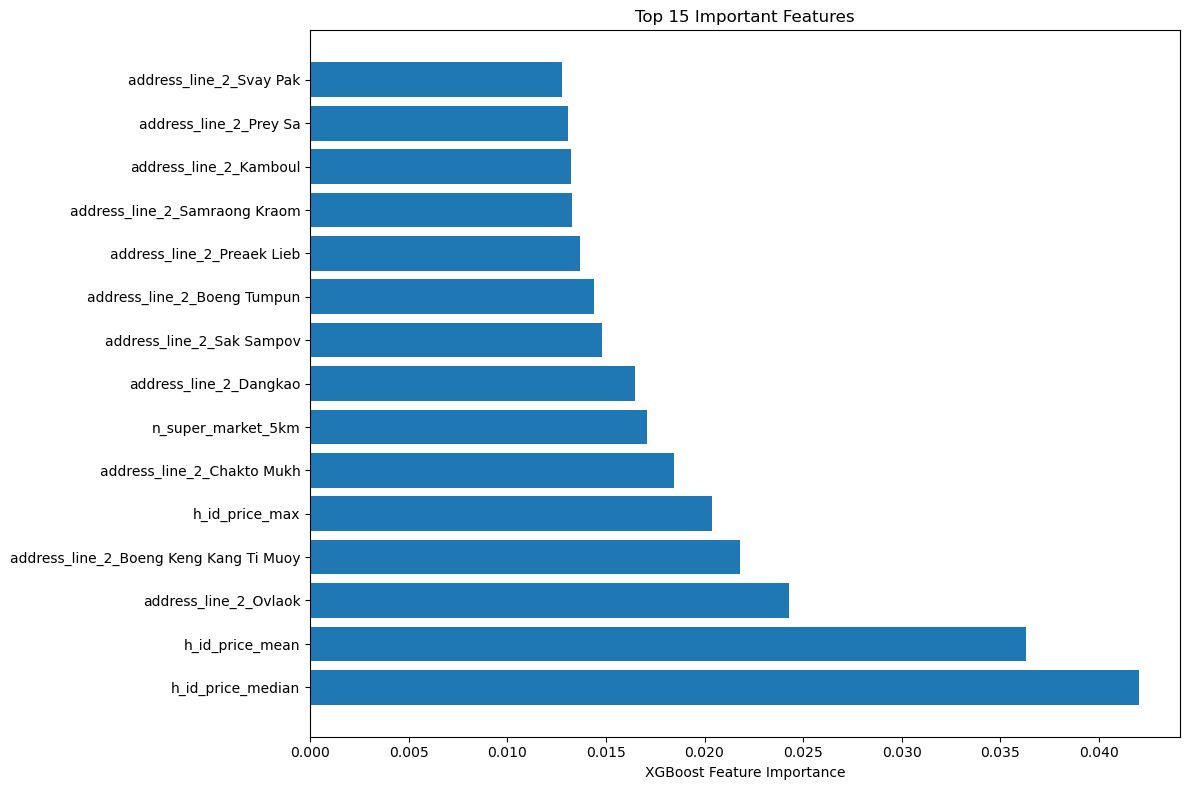

In [57]:
feature_importance = best_xgb.feature_importances_
sorted_idx = np.argsort(feature_importance)[::-1]

plt.figure(figsize=(12, 8))
plt.barh(range(15), feature_importance[sorted_idx][:15], align='center')
plt.yticks(range(15), X.columns[sorted_idx][:15])
plt.xlabel("XGBoost Feature Importance")
plt.title("Top 15 Important Features")
plt.tight_layout()
plt.savefig("xgboost_feature_importance.png", dpi=300)
plt.show()

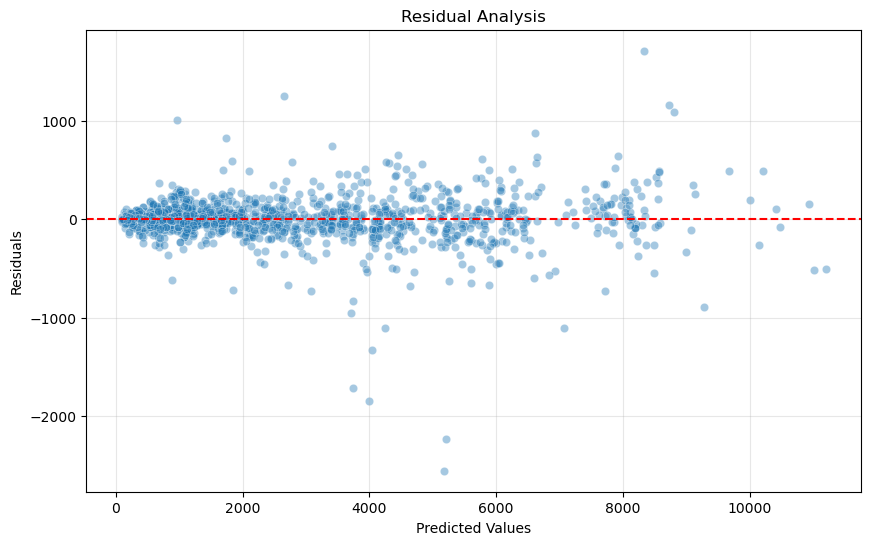

In [58]:
residuals = y_test - y_pred_test
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred_test, y=residuals, alpha=0.4)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Analysis")
plt.grid(alpha=0.3)
plt.savefig("xgboost_residuals.png", dpi=300)
plt.show()



Top 10 Worst Predictions:


,Actual,Predicted,Error
5096,89.82,89.778709,0.041291
6304,97.68,97.611176,0.068824
6822,142.56,142.485672,0.074328
7700,360.52,360.408508,0.111492
5314,513.71,513.583679,0.126321
...,...,...,...
3003,10041.79,8327.948242,1713.841758
103,2031.02,3745.929688,1714.909687
2932,2148.47,4000.822266,1852.352266
19,2976.01,5210.452148,2234.442148


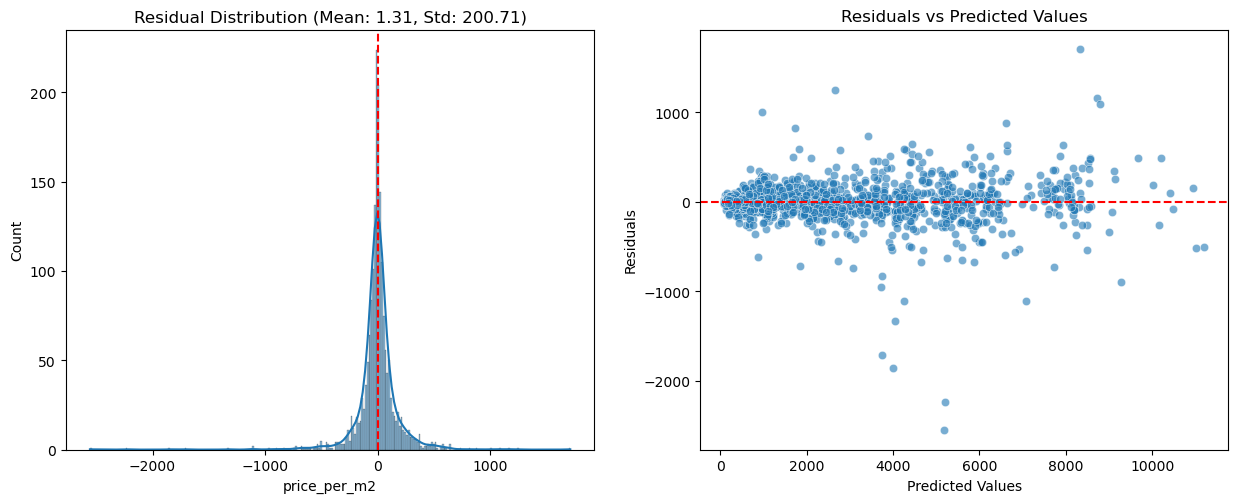

In [59]:
def analyze_residuals(y_true, y_pred):
    residuals = y_true - y_pred
    residual_mean = residuals.mean()
    residual_std = residuals.std()
    
    plt.figure(figsize=(15, 12))
    
    # Residual distribution
    plt.subplot(221)
    sns.histplot(residuals, kde=True)
    plt.axvline(residual_mean, color='r', linestyle='--')
    plt.title(f'Residual Distribution (Mean: {residual_mean:.2f}, Std: {residual_std:.2f})')
    
    # Residuals vs Predicted values
    plt.subplot(222)
    sns.scatterplot(x=y_pred, y=residuals, alpha=0.6)
    plt.axhline(0, color='r', linestyle='--')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title('Residuals vs Predicted Values')

    # Identify worst predictions
    worst_indices = np.argsort(np.abs(residuals))
    worst_samples = X_test.iloc[worst_indices].copy()
    worst_samples['Actual'] = y_true.iloc[worst_indices]
    worst_samples['Predicted'] = y_pred[worst_indices]
    worst_samples['Error'] = np.abs(worst_samples['Actual'] - worst_samples['Predicted'])
    
    print("\nTop 10 Worst Predictions:")
    display(worst_samples[['Actual', 'Predicted', 'Error']])
    
    return worst_samples

# Run analysis
worst_predictions = analyze_residuals(y_test, y_pred_test)

In [60]:
from sklearn.ensemble import GradientBoostingRegressor

def residual_correction_model(X_train, y_train, X_test, base_model):
    # Base model predictions
    base_model.fit(X_train, y_train)
    train_pred = base_model.predict(X_train)
    test_pred = base_model.predict(X_test)
    
    # Calculate residuals
    train_residuals = y_train - train_pred
    
    # Train residual correction model
    residual_model = GradientBoostingRegressor(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=3,
        random_state=42
    )
    residual_model.fit(X_train, train_residuals)
    
    # Apply correction
    train_correction = residual_model.predict(X_train)
    test_correction = residual_model.predict(X_test)
    
    # Final predictions
    final_train_pred = train_pred + train_correction
    final_test_pred = test_pred + test_correction
    
    return final_train_pred, final_test_pred, residual_model

# Apply residual correction
final_train_pred, final_test_pred, residual_model = residual_correction_model(
    X_train, y_train, X_test, best_xgb
)

# Evaluate corrected model
print("\nAfter Residual Correction:")
print_metrics(y_train, final_train_pred, "Train")
print_metrics(y_test, final_test_pred, "Test")


After Residual Correction:

Train Metrics:
R²: 0.9974
MAE: 54.93
MAPE: 6.02%

Test Metrics:
R²: 0.9922
MAE: 104.06
MAPE: 8.33%
Avg Price: 2074.79


104.06043129508939

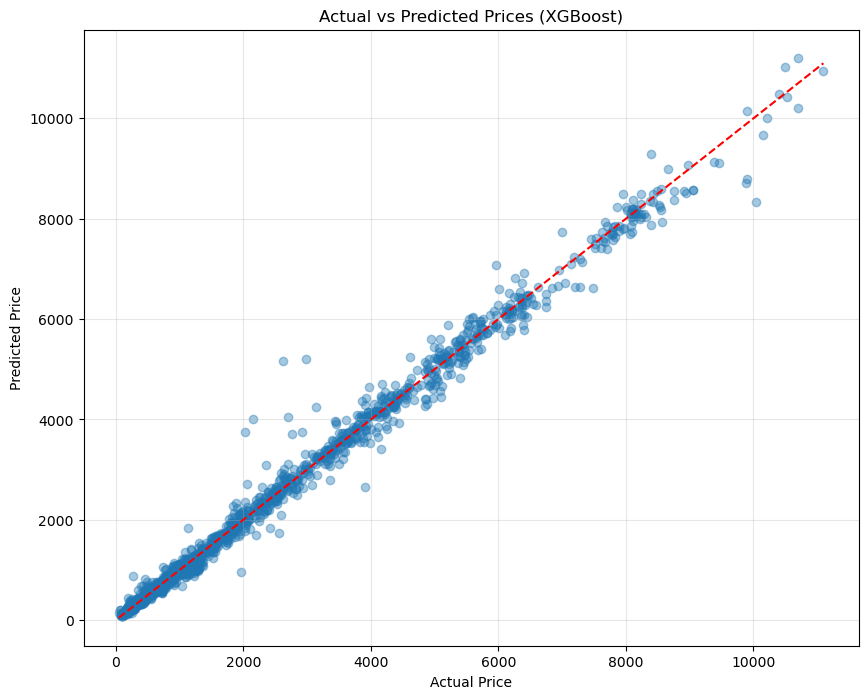

In [61]:
plt.figure(figsize=(10, 8))
plt.scatter(y_test, y_pred_test, alpha=0.4)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted Prices (XGBoost)")
plt.grid(alpha=0.3)
plt.savefig("xgboost_actual_vs_predicted.png", dpi=300)
plt.show()


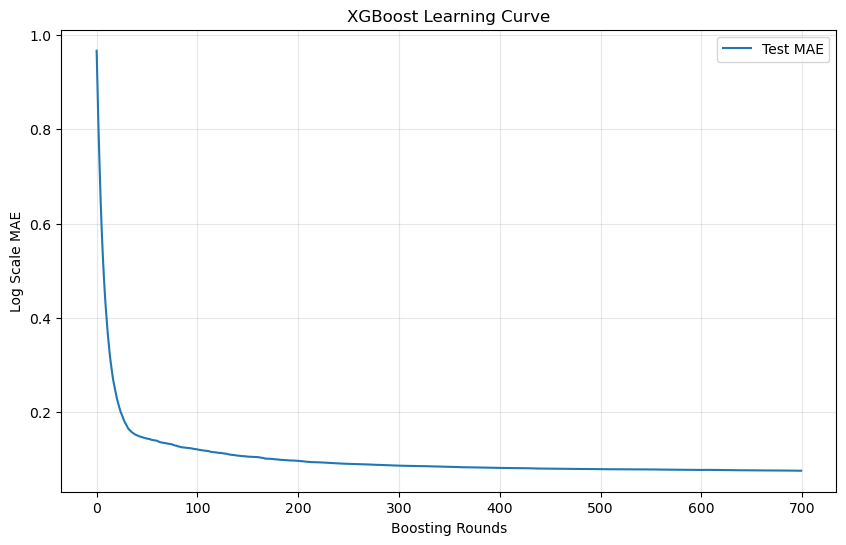

In [62]:
results = best_xgb.evals_result()
plt.figure(figsize=(10, 6))
plt.plot(results['validation_0']['mae'], label='Test MAE')
plt.xlabel('Boosting Rounds')
plt.ylabel('Log Scale MAE')
plt.title('XGBoost Learning Curve')
plt.legend()
plt.grid(alpha=0.3)
plt.savefig("xgboost_learning_curve.png", dpi=300)
plt.show()

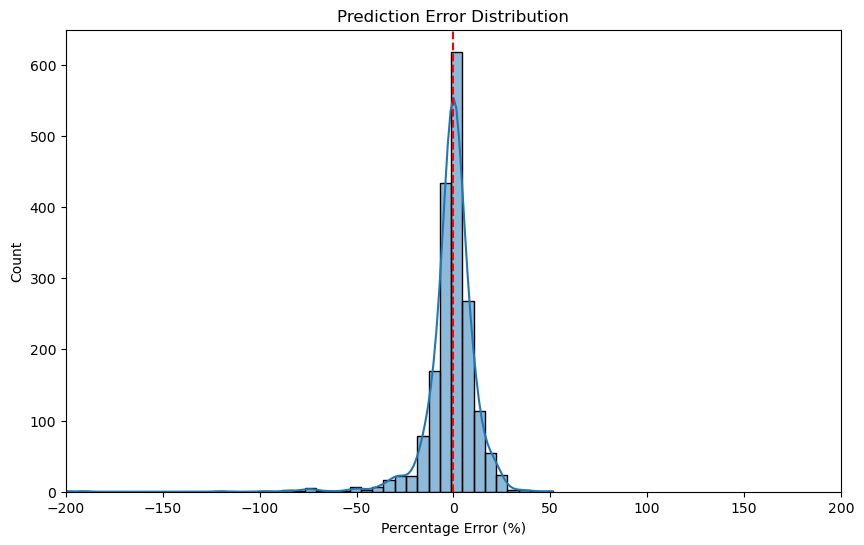

In [63]:
error_percentage = (residuals / y_test) * 100
plt.figure(figsize=(10, 6))
sns.histplot(error_percentage, bins=50, kde=True)
plt.axvline(x=0, color='r', linestyle='--')
plt.xlabel('Percentage Error (%)')
plt.title('Prediction Error Distribution')
plt.xlim([-200, 200])  # Focus on ±200% error range
plt.savefig("error_distribution.png", dpi=300)
plt.show()

In [64]:
cv_scores = cross_val_score(
    best_xgb,
    X_train_scaled,
    y_train_log,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1
)
cv_mae = -cv_scores.mean()
print(f"\nCross-Validation MAE: {cv_mae:.4f} ± {cv_scores.std():.4f}")


Cross-Validation MAE: 0.0775 ± 0.0028
